In [1]:
!pip install autogluon


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import modules
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from autogluon.tabular import TabularPredictor
from autogluon.common.space import Categorical, Real, Int


In [3]:
# Load and prepare data
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["target"])

In [4]:
# Split data (70% train, 10% val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [5]:
# Defining Model
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [6]:
# Manual Training
def manual_train(batch_size, lr, epochs):
    model = IrisNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to tensors
    X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.values.flatten(), dtype=torch.long)

    # Store training history
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            outputs = model(X_tensor[i:i+batch_size])
            loss = criterion(outputs, y_tensor[i:i+batch_size])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        history['train_loss'].append(epoch_loss/len(X_train))

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val.values, dtype=torch.float32))
            val_loss = criterion(val_outputs, torch.tensor(y_val.values.flatten(), dtype=torch.long))
            history['val_loss'].append(val_loss.item())

    # Test evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
        test_preds = torch.argmax(test_outputs, 1).numpy()

    return {
        'metrics': (accuracy_score(y_test, test_preds),
                   f1_score(y_test, test_preds, average='weighted')),
        'history': history,
        'model': model,
        'preds': test_preds
    }


In [7]:
# Run manual search (Grid Search)
manual_results = []
configs = [(bs, lr, ep) for bs in [2,4] for lr in [1e-3,1e-5] for ep in [1,3,5]]

for bs, lr, ep in configs:
    result = manual_train(bs, lr, ep)
    manual_results.append({
        'batch_size': bs,
        'lr': lr,
        'epochs': ep,
        'accuracy': result['metrics'][0],
        'f1': result['metrics'][1],
        'history': result['history'],
        'model': result['model'],
        'preds': result['preds']
    })

# Create comparison dataframe
manual_df = pd.DataFrame(manual_results)

In [8]:
# Performance for each hyperparameter combination over accuracy and F1.
acc_f1_df = pd.DataFrame([
    {
        'Batch Size': res['batch_size'],
        'Learning Rate': f"{res['lr']:.0e}",
        'Epochs': res['epochs'],
        'Accuracy': res['accuracy'],
        'F1 Score': res['f1']
    }
    for res in manual_results
])

print("\nHyperparameter Results Summary:")
acc_f1_df


Hyperparameter Results Summary:


,Batch Size,Learning Rate,Epochs,Accuracy,F1 Score
0,2,1e-03,1,0.366667,0.230180
1,2,1e-03,3,0.700000,0.593548
2,2,1e-03,5,0.700000,0.593548
3,2,1e-05,1,0.333333,0.166667
4,2,1e-05,3,0.333333,0.166667
5,2,1e-05,5,0.300000,0.138462
6,4,1e-03,1,0.633333,0.519540
7,4,1e-03,3,0.366667,0.196748
8,4,1e-03,5,0.700000,0.593548
9,4,1e-05,1,0.333333,0.166667


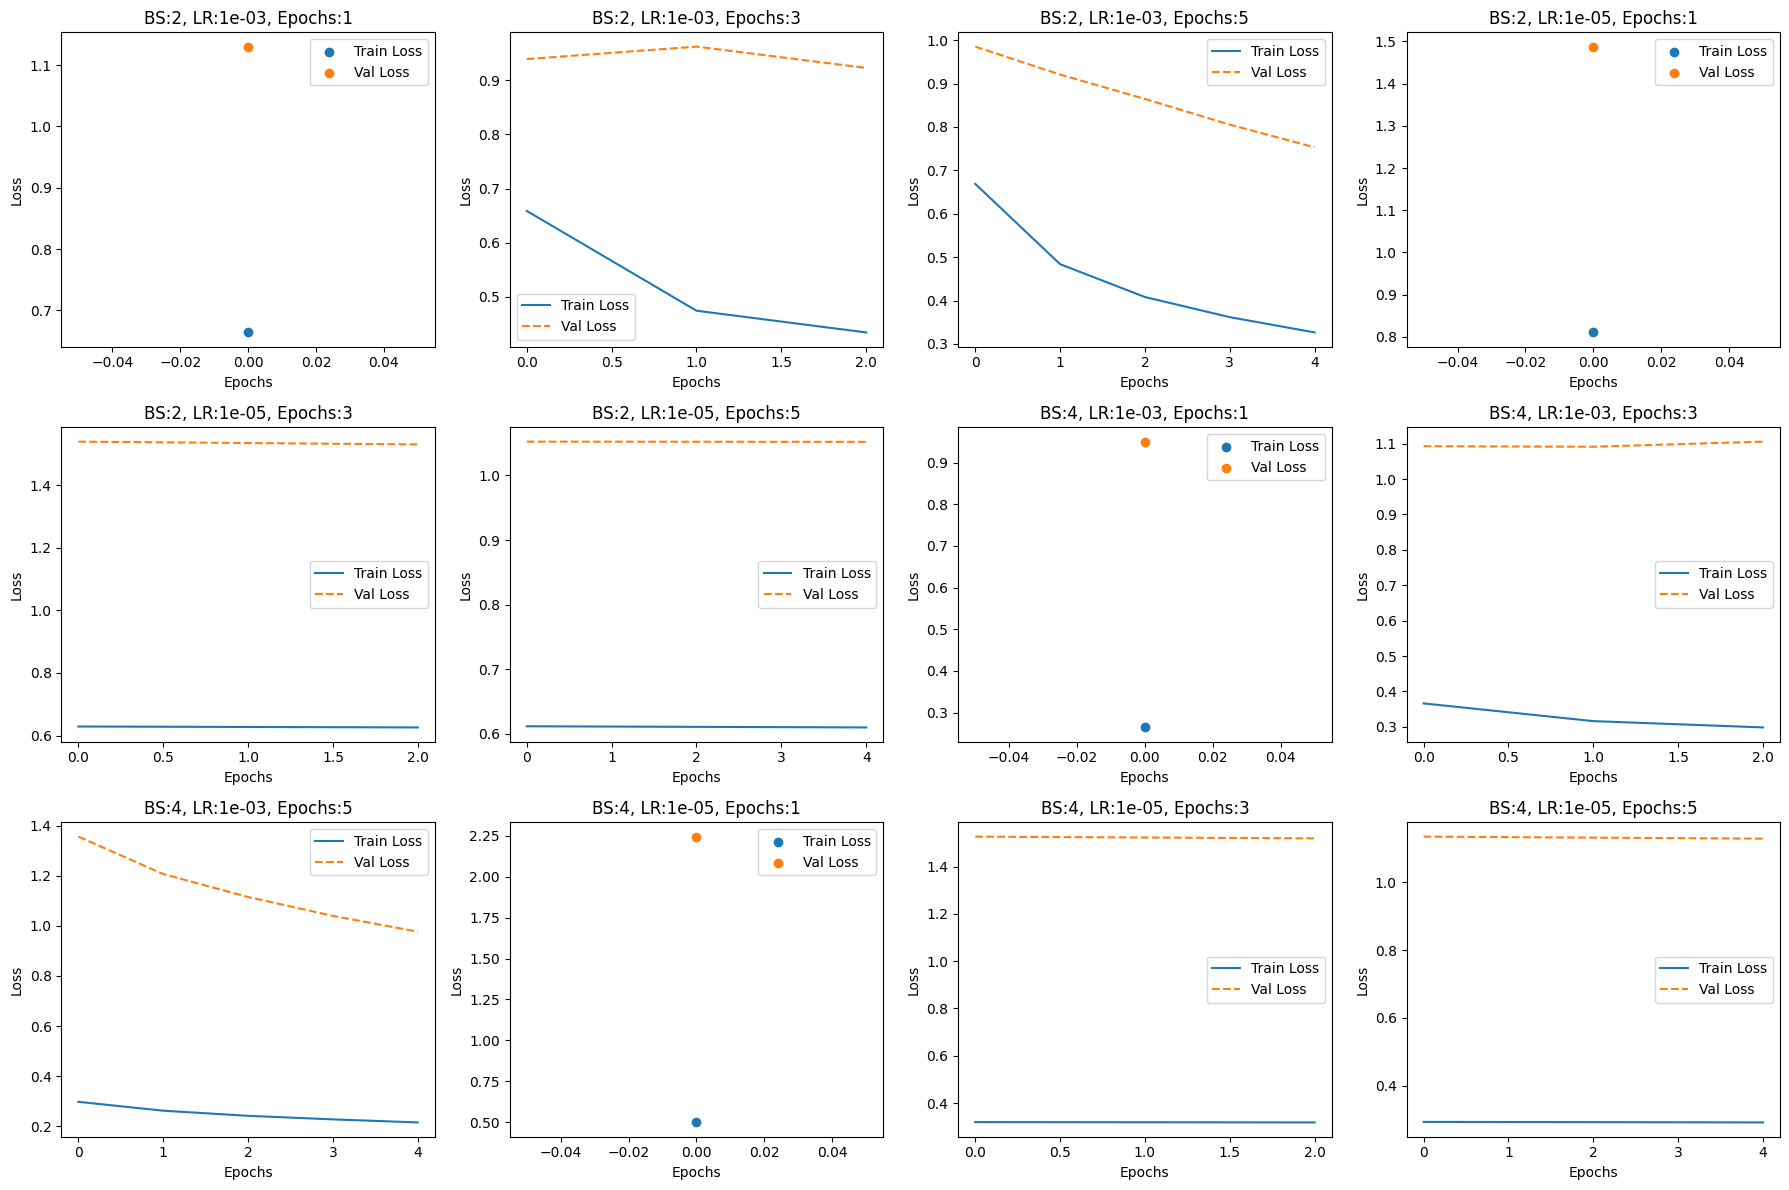

In [9]:
# Validation and Training Loss curves
plt.figure(figsize=(18, 12))

num_results = len(manual_results)

for i, res in enumerate(manual_results):
    if res['epochs'] == 1:
        plt.subplot(3, 4, i + 1)
        label = f"BS:{res['batch_size']}, LR:{res['lr']:.0e}, Epochs:{res['epochs']}"

        plt.scatter([0], res['history']['train_loss'], label='Train Loss')  # Scatter plot for only 1 epoch
        plt.scatter([0], res['history']['val_loss'], label='Val Loss')  # Scatter plot for only 1 epoch

        plt.title(label)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        continue

    plt.subplot(3, 4, i + 1)
    label = f"BS:{res['batch_size']}, LR:{res['lr']:.0e}, Epochs:{res['epochs']}"

    plt.plot(res['history']['train_loss'], label='Train Loss')
    plt.plot(res['history']['val_loss'], '--', label='Val Loss')

    plt.title(label)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.show()

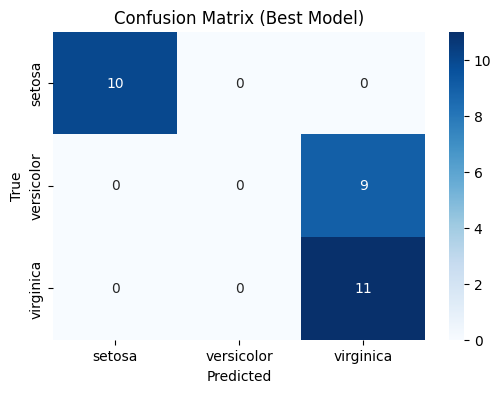

In [10]:
# Plot confusion matrix for best model
best_model = manual_df.loc[manual_df['f1'].idxmax()]
cm = confusion_matrix(y_test, best_model['preds'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=data.target_names,
           yticklabels=data.target_names)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

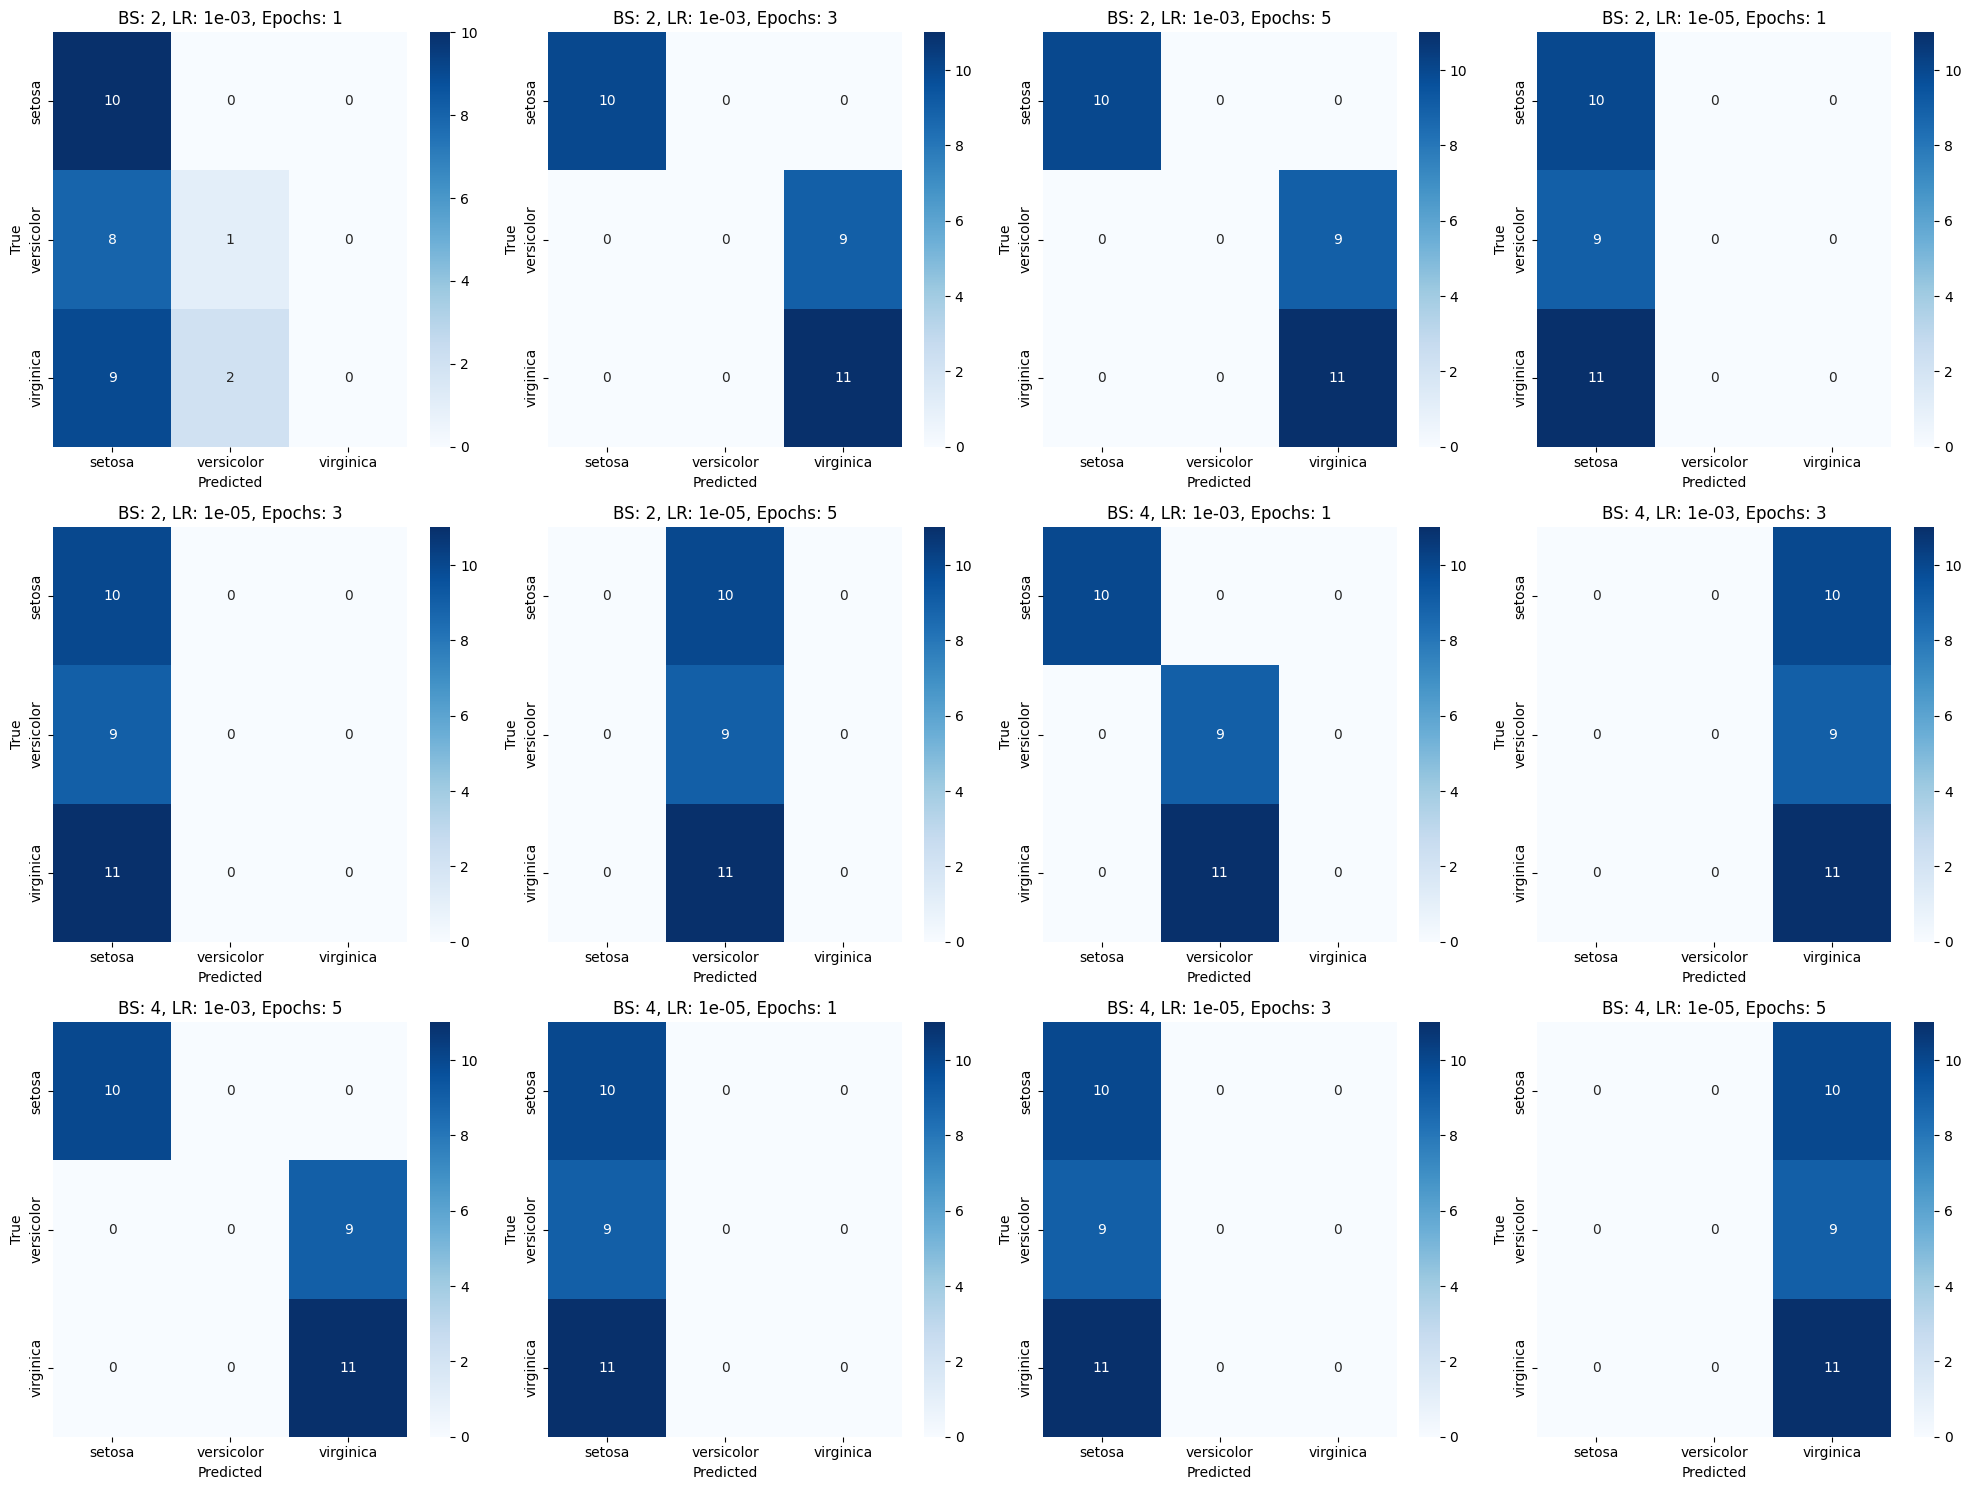

In [11]:
# Plot confusion matrices for all hyperparameter combinations
rows = 3
cols = 4

plt.figure(figsize=(cols * 5, rows * 5))

# Loop through each model result
for i, res in enumerate(manual_results):
    cm = confusion_matrix(y_test, res['preds'])

    plt.subplot(rows, cols, i + 1)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=data.target_names,
                yticklabels=data.target_names)

    plt.title(f"BS: {res['batch_size']}, LR: {res['lr']:.0e}, Epochs: {res['epochs']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

In [12]:
# Show 5 sample predictions for best model
sample_idx = np.random.choice(len(X_test), 5, replace=False)
print("\nSample Predictions:")
for idx in sample_idx:
    features = X_test.iloc[idx].values
    true = data.target_names[y_test.iloc[idx].values[0]]
    pred = data.target_names[best_model['preds'][idx]]
    print(f"Features: {features} | Predicted: {pred:8} | True: {true}")


Sample Predictions:
Features: [6.8 2.8 4.8 1.4] | Predicted: virginica | True: versicolor
Features: [5.5 3.5 1.3 0.2] | Predicted: setosa   | True: setosa
Features: [6.9 3.1 5.1 2.3] | Predicted: virginica | True: virginica
Features: [6.3 3.3 4.7 1.6] | Predicted: virginica | True: versicolor
Features: [7.7 2.6 6.9 2.3] | Predicted: virginica | True: virginica


In [13]:
# Show 5 sample predictions for each model
print("\nSample Predictions for Each Model:\n")

for res in manual_results:
    print(f"\nModel - BS: {res['batch_size']}, LR: {res['lr']:.0e}, Epochs: {res['epochs']}\n")

    # Randomly select 5 test samples
    sample_idx = np.random.choice(len(X_test), 5, replace=False)

    for idx in sample_idx:
        features = X_test.iloc[idx].values
        true = data.target_names[y_test.iloc[idx].values[0]]
        pred = data.target_names[res['preds'][idx]]

        print(f"Features: {features} | Predicted: {pred:12} | True: {true}")



Sample Predictions for Each Model:


Model - BS: 2, LR: 1e-03, Epochs: 1

Features: [7.7 2.6 6.9 2.3] | Predicted: versicolor   | True: virginica
Features: [6.8 2.8 4.8 1.4] | Predicted: setosa       | True: versicolor
Features: [5.5 3.5 1.3 0.2] | Predicted: setosa       | True: setosa
Features: [4.8 3.  1.4 0.3] | Predicted: setosa       | True: setosa
Features: [6.8 3.2 5.9 2.3] | Predicted: setosa       | True: virginica

Model - BS: 2, LR: 1e-03, Epochs: 3

Features: [4.9 3.1 1.5 0.1] | Predicted: setosa       | True: setosa
Features: [5.7 3.8 1.7 0.3] | Predicted: setosa       | True: setosa
Features: [4.8 3.  1.4 0.3] | Predicted: setosa       | True: setosa
Features: [6.4 2.8 5.6 2.1] | Predicted: virginica    | True: virginica
Features: [7.9 3.8 6.4 2. ] | Predicted: virginica    | True: virginica

Model - BS: 2, LR: 1e-03, Epochs: 5

Features: [4.7 3.2 1.6 0.2] | Predicted: setosa       | True: setosa
Features: [5.7 3.8 1.7 0.3] | Predicted: setosa       | True: setosa
Featu

# Autogluon

In [14]:
# Autogluon Search
def run_autogluon_search(method):
    try:
        hyperparams = {
            'NN_TORCH': {
                'num_epochs': Int(1,3,5),
                'learning_rate': Real(1e-5,1e-3),
                'batch_size': Categorical(2,4)
            }
        }

        path = f"{method}_model"
        if os.path.exists(path):
            shutil.rmtree(path)

        predictor = TabularPredictor(
            label="target",
            path=path,
            eval_metric='f1_weighted'
        ).fit(
            train_data=pd.concat([X_train, y_train], axis=1),
            tuning_data=pd.concat([X_val, y_val], axis=1),
            hyperparameters=hyperparams,
            hyperparameter_tune_kwargs={
                'num_trials': 5,
                'searcher': method,
                'scheduler': 'local'
            },
            time_limit=300
        )

        test_pred = predictor.predict(pd.concat([X_test, y_test], axis=1))
        return {
            'accuracy': accuracy_score(y_test, test_pred),
            'f1': f1_score(y_test, test_pred, average='weighted')
        }
    except Exception as e:
        print(f"{method} search failed: {str(e)}")
        return {'accuracy':0, 'f1':0}


In [15]:
# Random Search
random_result = run_autogluon_search('random')

Fitted model: NeuralNetTorch\c2a53_00000 ...
	0.8667	 = Validation score   (f1_weighted)
	20.76s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\c2a53_00001 ...
	0.7209	 = Validation score   (f1_weighted)
	21.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\c2a53_00002 ...
	1.0	 = Validation score   (f1_weighted)
	20.22s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch\c2a53_00003 ...
	1.0	 = Validation score   (f1_weighted)
	18.98s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: NeuralNetTorch\c2a53_00004 ...
	0.4423	 = Validation score   (f1_weighted)
	19.82s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.67s of the 237.48s of remaining time.
	Ensemble Weights: {'NeuralNetTorch\c2a53_00002': 1.0}
	1.0	 = Validation score   (f1_weighted)
	0.04s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGlu

In [16]:
# Bayesian Optimization
bayes_result = run_autogluon_search('bayes')

Fitted model: NeuralNetTorch\2ed146ea ...
	0.8667	 = Validation score   (f1_weighted)
	11.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\3c6477f9 ...
	0.7333	 = Validation score   (f1_weighted)
	12.88s	 = Training   runtime
	0.05s	 = Validation runtime
Fitted model: NeuralNetTorch\63a2fd4c ...
	0.7209	 = Validation score   (f1_weighted)
	12.64s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\77e7233e ...
	0.6737	 = Validation score   (f1_weighted)
	7.5s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\56014ba9 ...
	0.9348	 = Validation score   (f1_weighted)
	7.11s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.68s of the 255.49s of remaining time.
	Ensemble Weights: {'NeuralNetTorch\56014ba9': 1.0}
	0.9348	 = Validation score   (f1_weighted)
	0.03s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training

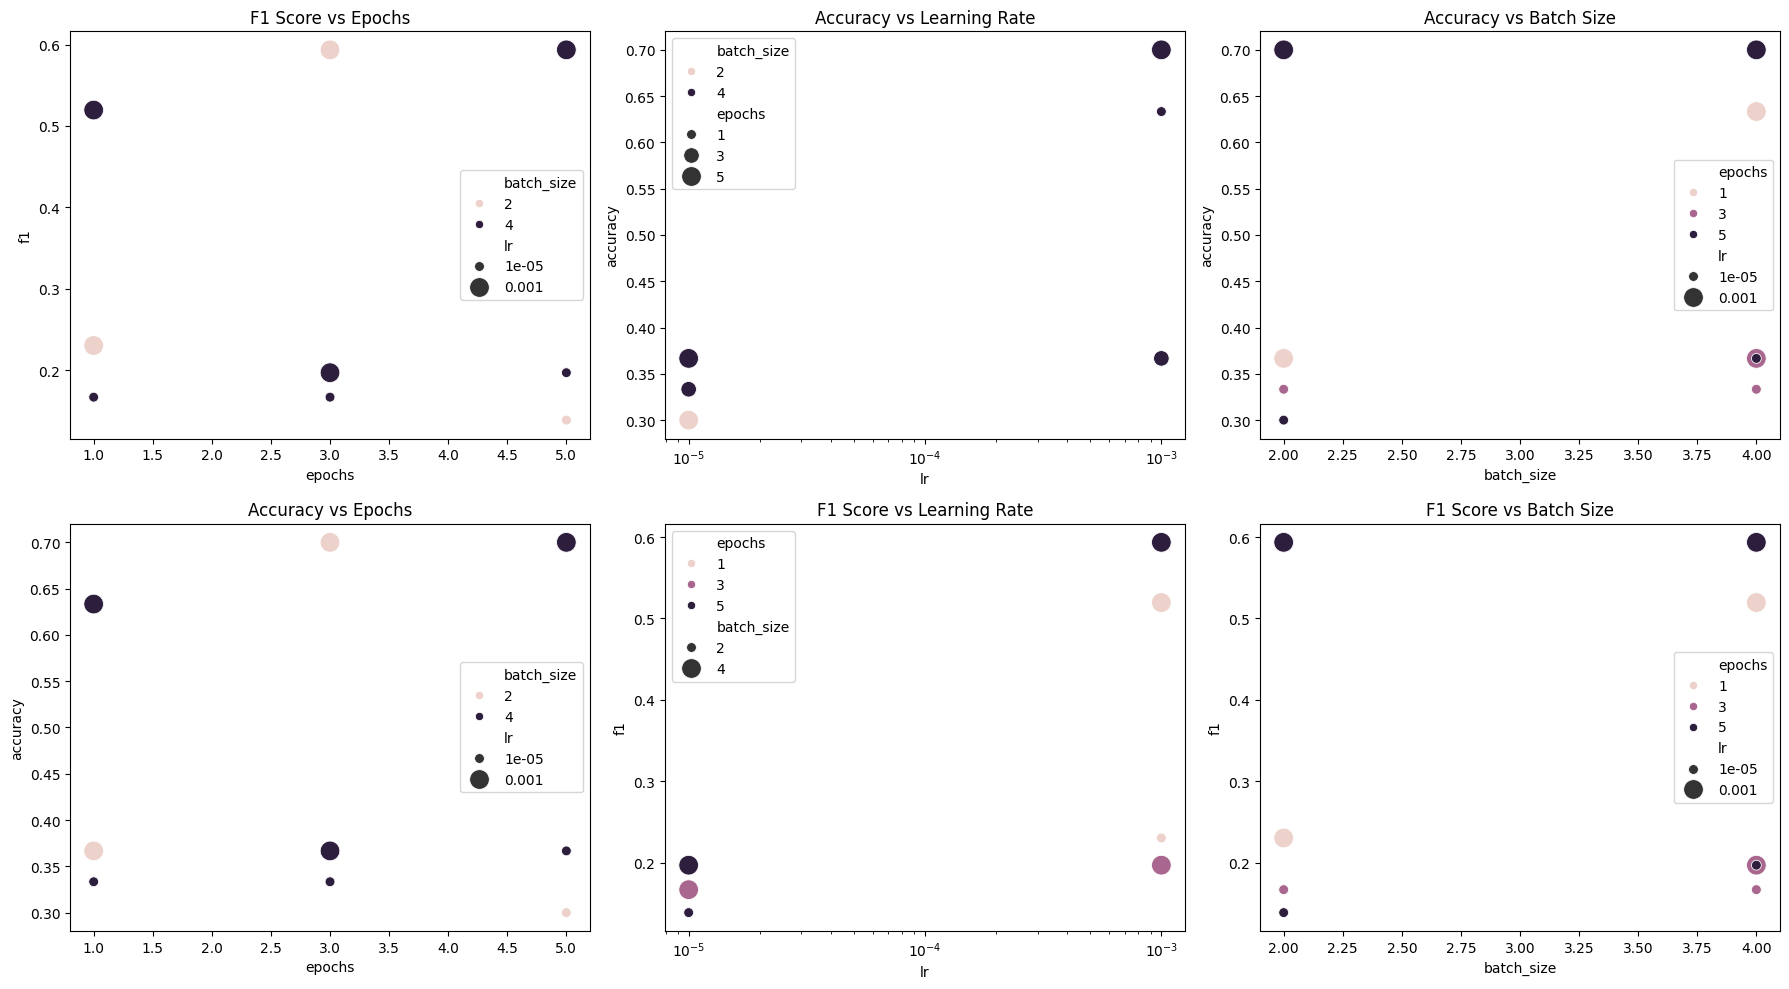

In [17]:
# Scatterplots to explore hyperparameter effects
plt.figure(figsize=(18, 10))

# F1 Score vs Epochs
plt.subplot(2,3,1)
sns.scatterplot(data=manual_df, x='epochs', y='f1', hue='batch_size', size='lr', sizes=(50, 200))
plt.title("F1 Score vs Epochs")

# Accuracy vs Learning Rate
plt.subplot(2,3,2)
sns.scatterplot(data=manual_df, x='lr', y='accuracy', hue='batch_size', size='epochs', sizes=(50, 200))
plt.xscale('log')  # Log scale for better LR visibility
plt.title("Accuracy vs Learning Rate")

# Accuracy vs Batch Size
plt.subplot(2,3,3)
sns.scatterplot(data=manual_df, x='batch_size', y='accuracy', hue='epochs', size='lr', sizes=(50, 200))
plt.title("Accuracy vs Batch Size")

# Accuracy vs Epochs
plt.subplot(2,3,4)
sns.scatterplot(data=manual_df, x='epochs', y='accuracy', hue='batch_size', size='lr', sizes=(50, 200))
plt.title("Accuracy vs Epochs")

# F1 Score vs Learning Rate
plt.subplot(2,3,5)
sns.scatterplot(data=manual_df, x='lr', y='f1', hue='epochs', size='batch_size', sizes=(50, 200))
plt.xscale('log')
plt.title("F1 Score vs Learning Rate")

# F1 Score vs Batch Size
plt.subplot(2,3,6)
sns.scatterplot(data=manual_df, x='batch_size', y='f1', hue='epochs', size='lr', sizes=(50, 200))
plt.title("F1 Score vs Batch Size")

plt.tight_layout()
plt.show()

In [18]:
# Final Comparison
comparison_data = {
    'Method': ['Manual Grid Search', 'Random Search', 'Bayesian Search'],
    'Accuracy': [manual_df['accuracy'].max(), random_result['accuracy'], bayes_result['accuracy']],
    'F1 Score': [manual_df['f1'].max(), random_result['f1'], bayes_result['f1']]
}
results_df = pd.DataFrame(comparison_data)
print("\nFinal Comparison:")
results_df


Final Comparison:


,Method,Accuracy,F1 Score
0,Manual Grid Search,0.700000,0.593548
1,Random Search,1.000000,1.000000
2,Bayesian Search,0.966667,0.966411


# Theoretical Analysis

1. Epochs vs. Performance: There is generally a direct relationship—more epochs allow the model to learn better by refining weights over multiple iterations. However, excessive epochs can lead to overfitting, where the model performs well on training data but poorly on unseen data.  

2. Batch Size vs. Performance: A smaller batch size results in more frequent weight updates, often leading to better generalization. However, too small a batch size can introduce high variance in updates, making convergence unstable. Conversely, larger batches offer smoother convergence but may get stuck in sharp minima instead of finding optimal solutions.  

3. Learning Rate: The choice of learning rate is crucial—too high may cause the model to overshoot optimal weights, while too low can lead to slow convergence. In this case, a mid-range value (1e-3) outperformed lower values (1e-5), as it balanced stability and speed.  

4. Automated vs. Manual Hyperparameter Tuning: Automated search methods outperform manual tuning by efficiently exploring a wider hyperparameter space, reducing human bias and trial-and-error inefficiencies.  

5. Best Hyperparameter Search Approach: Among automated techniques, Bayesian optimization provided the best results. This is because it balances exploration and exploitation, efficiently refining hyperparameters based on past evaluations instead of relying solely on random or exhaustive searches.